<h2 style="background-color:#006A71; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold;">
    Binary Prediction with a Rainfall
</h2>


![My Image](./images/bg_for_rainfall.jpg)

## 🏁 About the Tabular Playground Series

The **Tabular Playground Series** aims to provide the Kaggle community with a variety of _light-weight_ challenges designed to help participants:

- Learn and sharpen their machine learning and data science skills  
- Experiment with feature engineering and modeling techniques  
- Practice creating visualizations and insights  

Each competition generally lasts only a few weeks, though durations may vary depending on the complexity of the challenge.

---

## 🧪 Synthetically-Generated Datasets

To maintain a balance between **real-world relevance** and **data security**, the datasets used in Playground competitions are _synthetically generated_ based on real-world data. This approach:

- Allows use of named features without exposing real test labels  
- Makes the datasets more interesting and useful than fully anonymized data  
- Reduces the risk of label leakage while encouraging robust experimentation

The state-of-the-art in synthetic data generation has significantly improved since the series began two years ago. The goal is now to produce datasets with **fewer artifacts** and more realistic structures.

> 💬 *Your feedback on these datasets is valuable and helps improve future competitions!*


- **About the author:** Sajjad Ali Shah
- **LinkedIn:** [LinkedIn Profile](https://www.linkedin.com/in/sajjad-ali-shah47/)
- **Dataset link:** [Binary Prediction with a Rainfall Dataset](https://www.kaggle.com/competitions/playground-series-s5e3/overview)

---

<h2 style="background-color:#006A71; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold;">
    Import libraries
</h2>


In [13]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import pickle
import warnings
warnings.filterwarnings("ignore")

# Set visualization style
sns.set_theme(style="darkgrid")  # or "whitegrid", "dark", "white", "ticks"
sns.set_palette("coolwarm")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

<h2 style="background-color:#006A71; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold;">
    Load Datset
</h2>


In [3]:
# Load datasets
print("Loading datasets...")
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")

# Verify shapes
print("Train Data Shape:", df_train.shape)
print("Test Data Shape:", df_test.shape)
print("Sample Submission Shape:", sample_submission.shape)

Loading datasets...
Train Data Shape: (2190, 13)
Test Data Shape: (730, 12)
Sample Submission Shape: (730, 2)


In [4]:
# Handle missing values in test data
print("Handling missing values...")
df_test['winddirection'].fillna(df_test['winddirection'].mean(), inplace=True)
print("Missing Values in Test after Imputation:", df_test.isnull().sum().sum())

Handling missing values...
Missing Values in Test after Imputation: 0


<h2 style="background-color:#006A71; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold;">
    Visualizations
</h2>


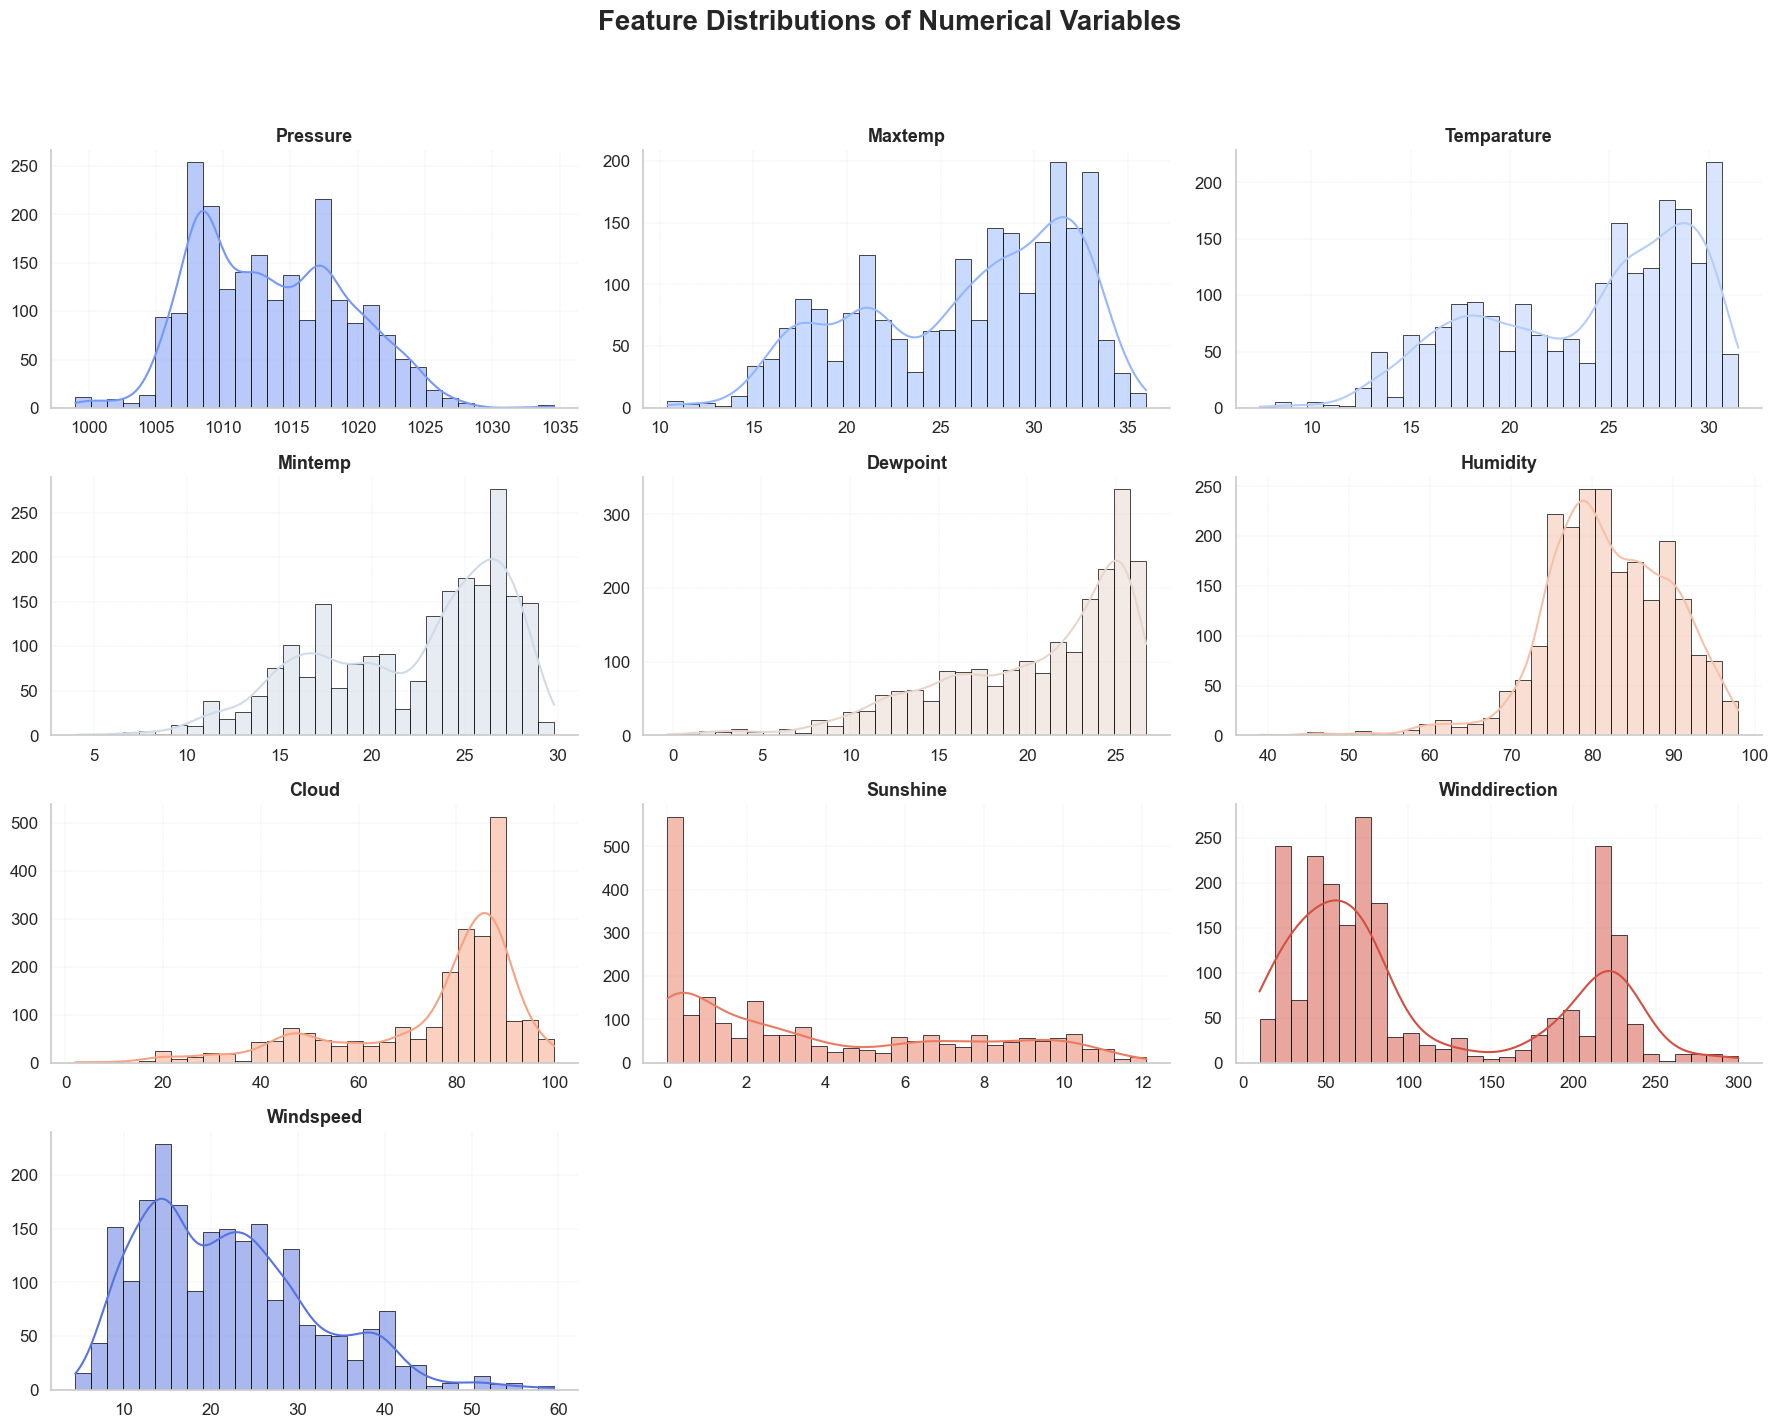

In [18]:
# Set a modern Seaborn style
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Define numerical features
numerical_variables = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 
                       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']

# Set up the matplotlib figure
plt.figure(figsize=(18, 14))
plt.suptitle("Feature Distributions of Numerical Variables", fontsize=20, fontweight='bold', y=1.02)

# Create subplots
for i, var in enumerate(numerical_variables, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df_train, x=var, kde=True, bins=30,
                 color=sns.color_palette("coolwarm", len(numerical_variables))[i % len(numerical_variables)],
                 edgecolor='black', linewidth=0.5)
    
    plt.title(f'{var.capitalize()}', fontsize=13, weight='bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.6)
    sns.despine()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


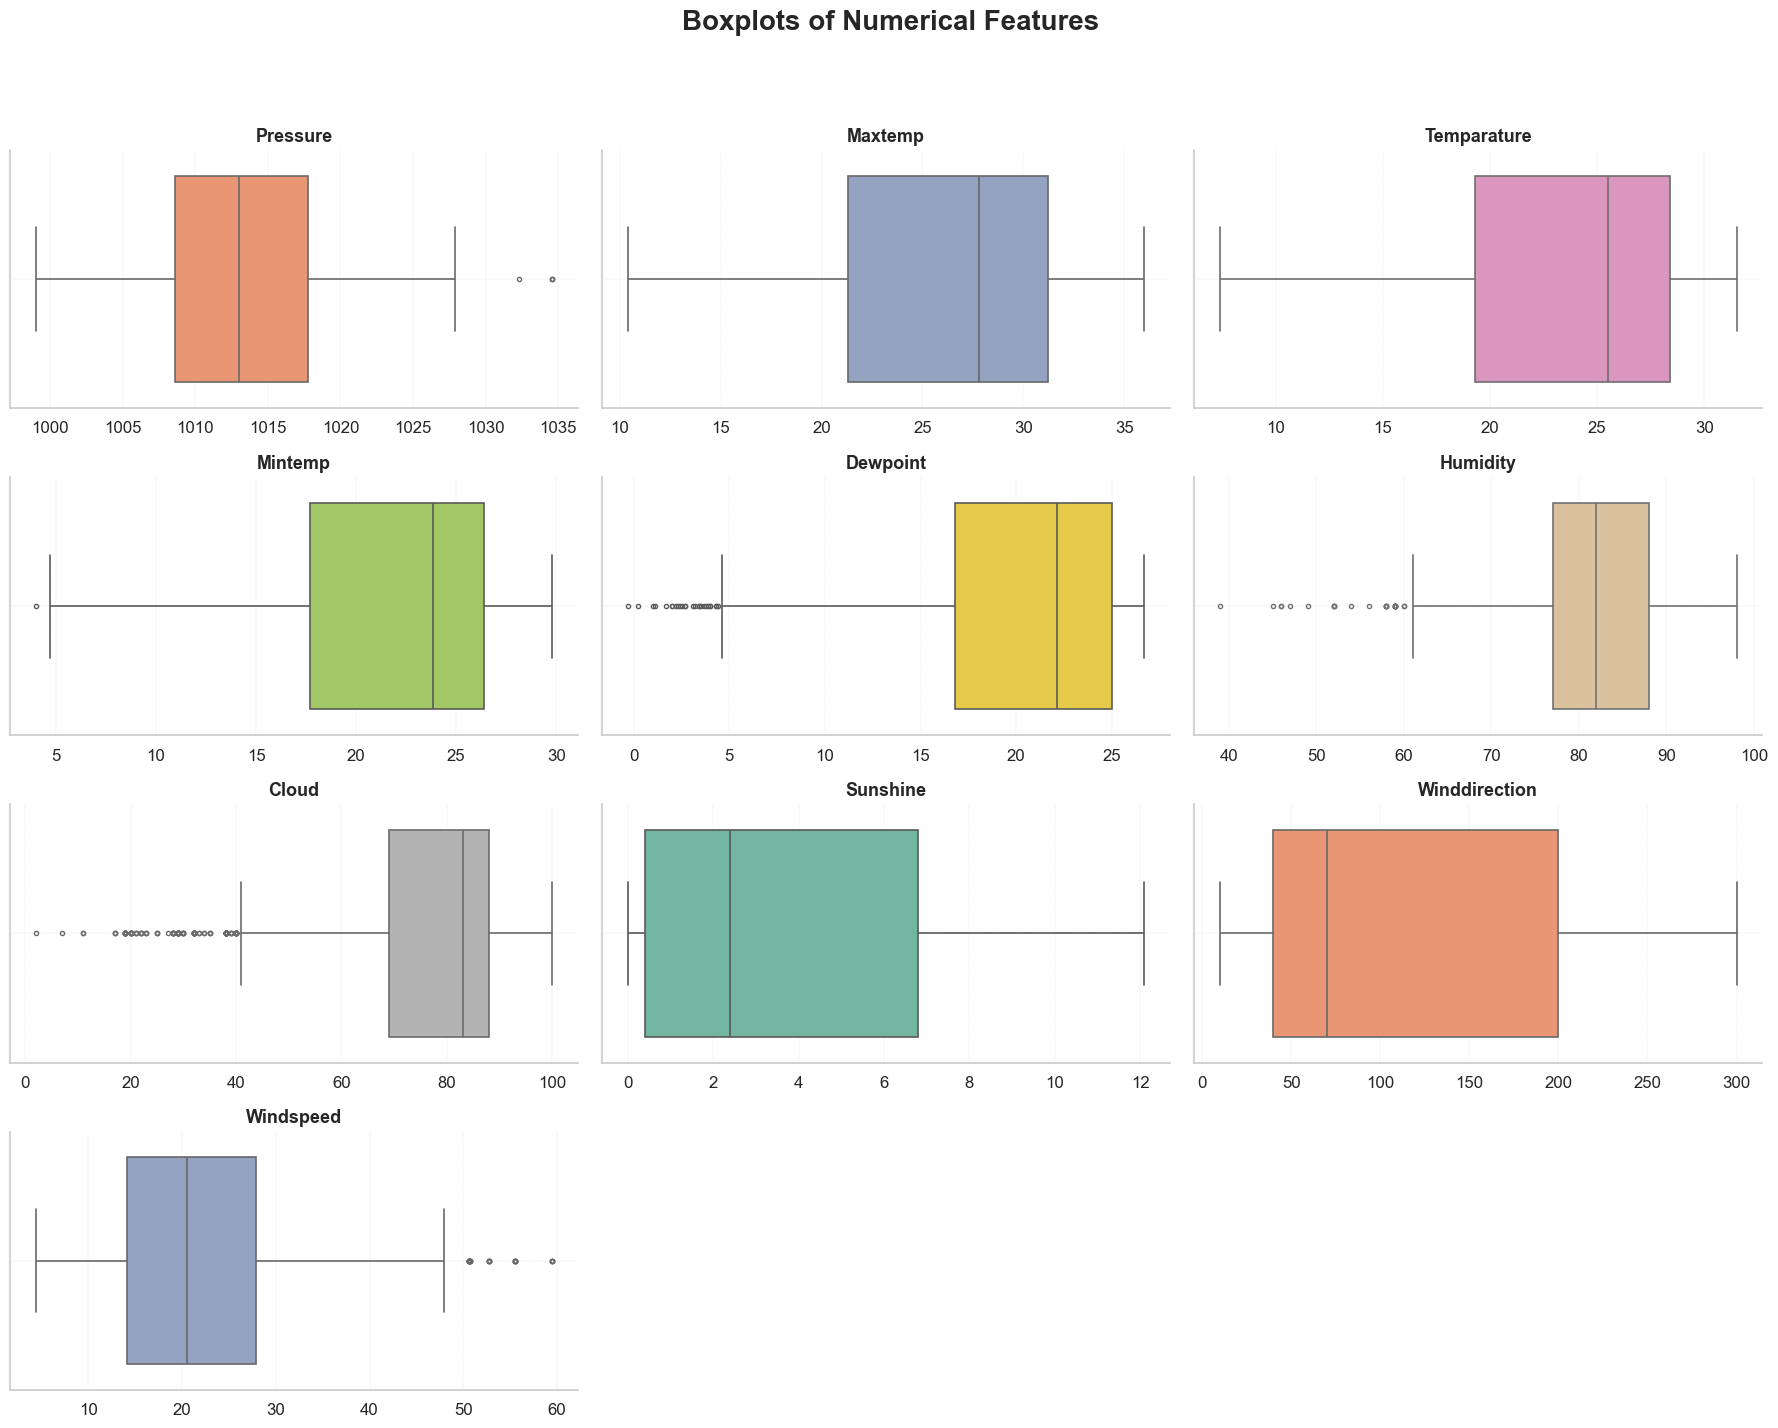

In [19]:
# Set Seaborn style and font scale
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

# Create boxplots with horizontal layout and better styling
plt.figure(figsize=(18, 14))
plt.suptitle("Boxplots of Numerical Features", fontsize=20, fontweight='bold', y=1.02)

for i, var in enumerate(numerical_variables, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=df_train, x=var,
                color=sns.color_palette("Set2")[i % len(sns.color_palette("Set2"))],
                linewidth=1.2, fliersize=3)
    
    plt.title(f"{var.capitalize()}", fontsize=13, weight='bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.6)
    sns.despine()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


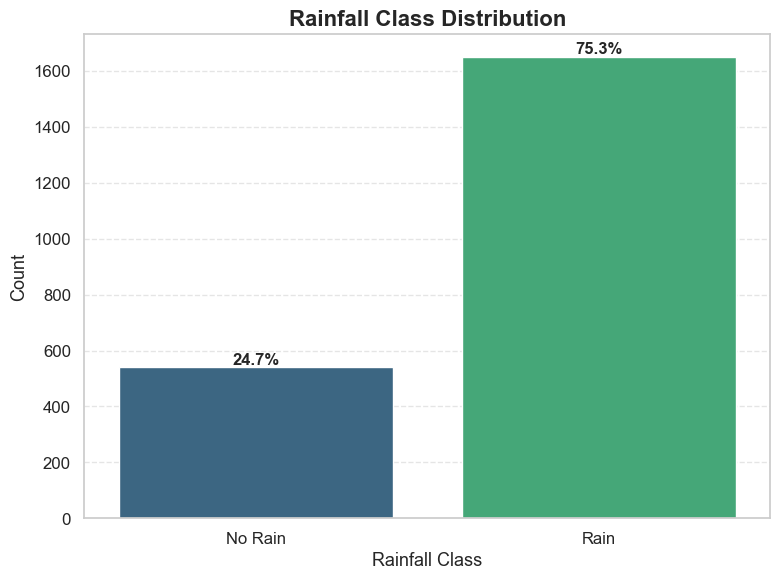

In [21]:
# Plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='rainfall', data=df_train, palette='viridis')

# Add percentages on top
total = len(df_train)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels
ax.set_xticklabels(['No Rain', 'Rain'], fontsize=12)
plt.title('Rainfall Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Rainfall Class', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


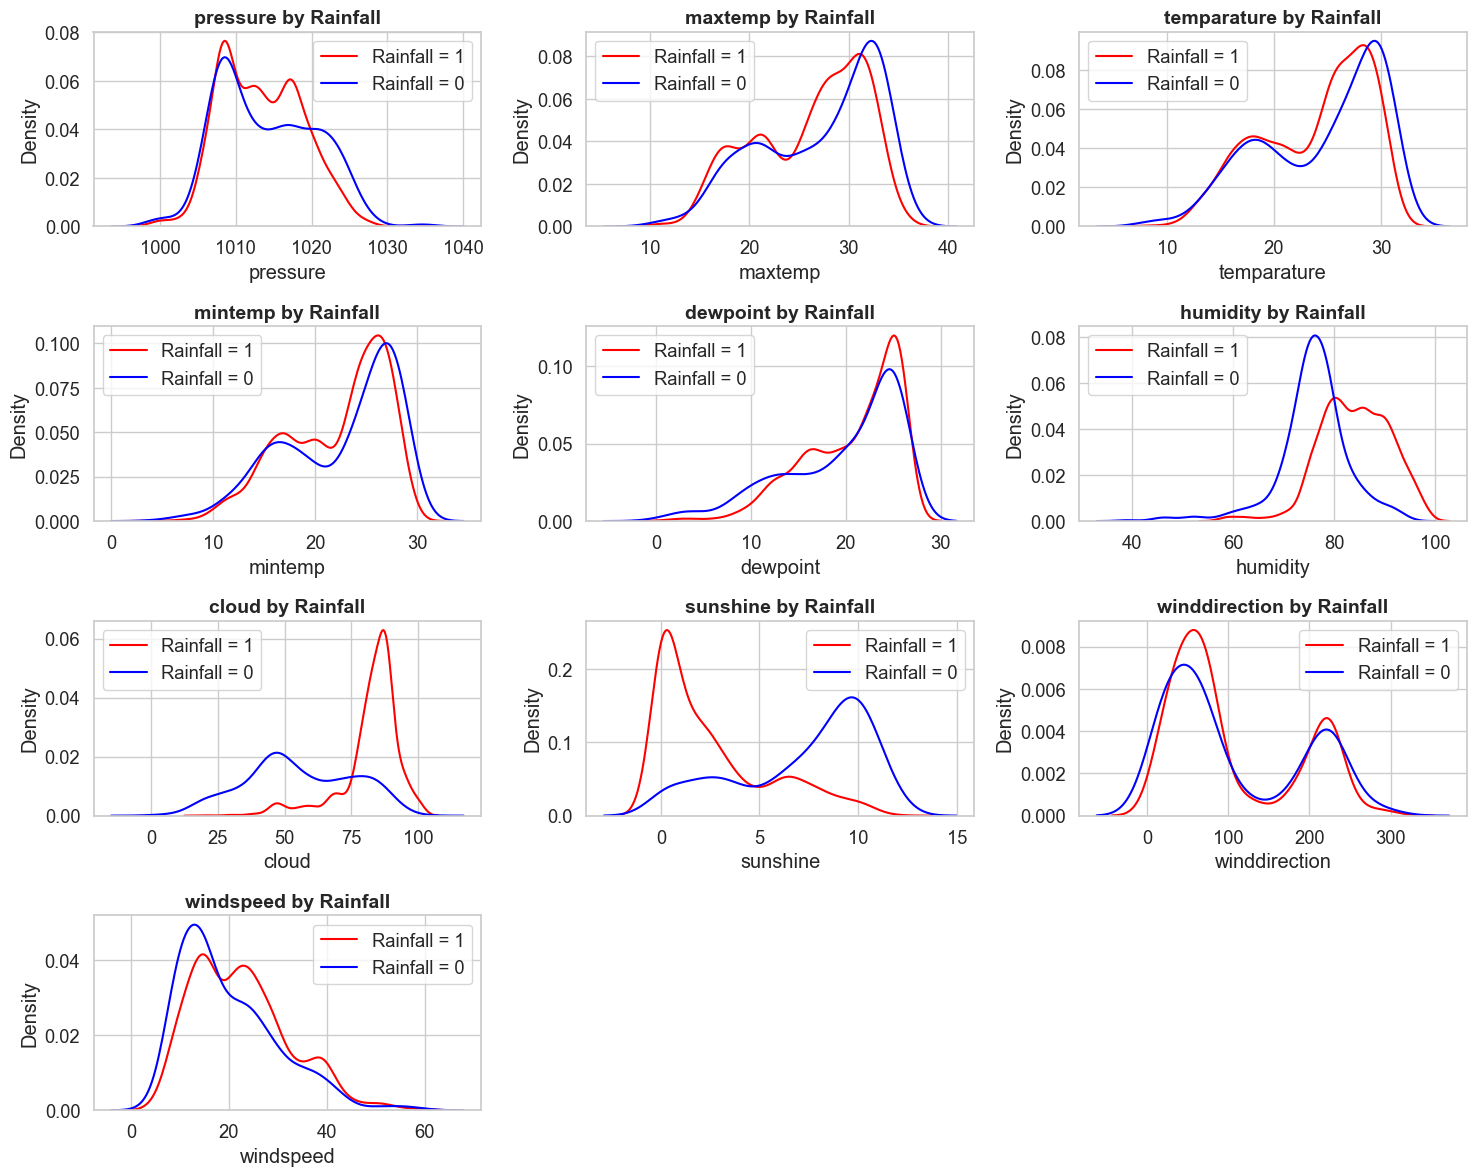

In [23]:
# KDE plots for feature-target relationships
plt.figure(figsize=(15, 12))
for i, var in enumerate(numerical_variables, 1):
    plt.subplot(4, 3, i)
    sns.kdeplot(data=df_train[df_train['rainfall'] == 1], x=var, label='Rainfall = 1', color='red')
    sns.kdeplot(data=df_train[df_train['rainfall'] == 0], x=var, label='Rainfall = 0', color='blue')
    plt.title(f'{var} by Rainfall', fontsize=14)
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

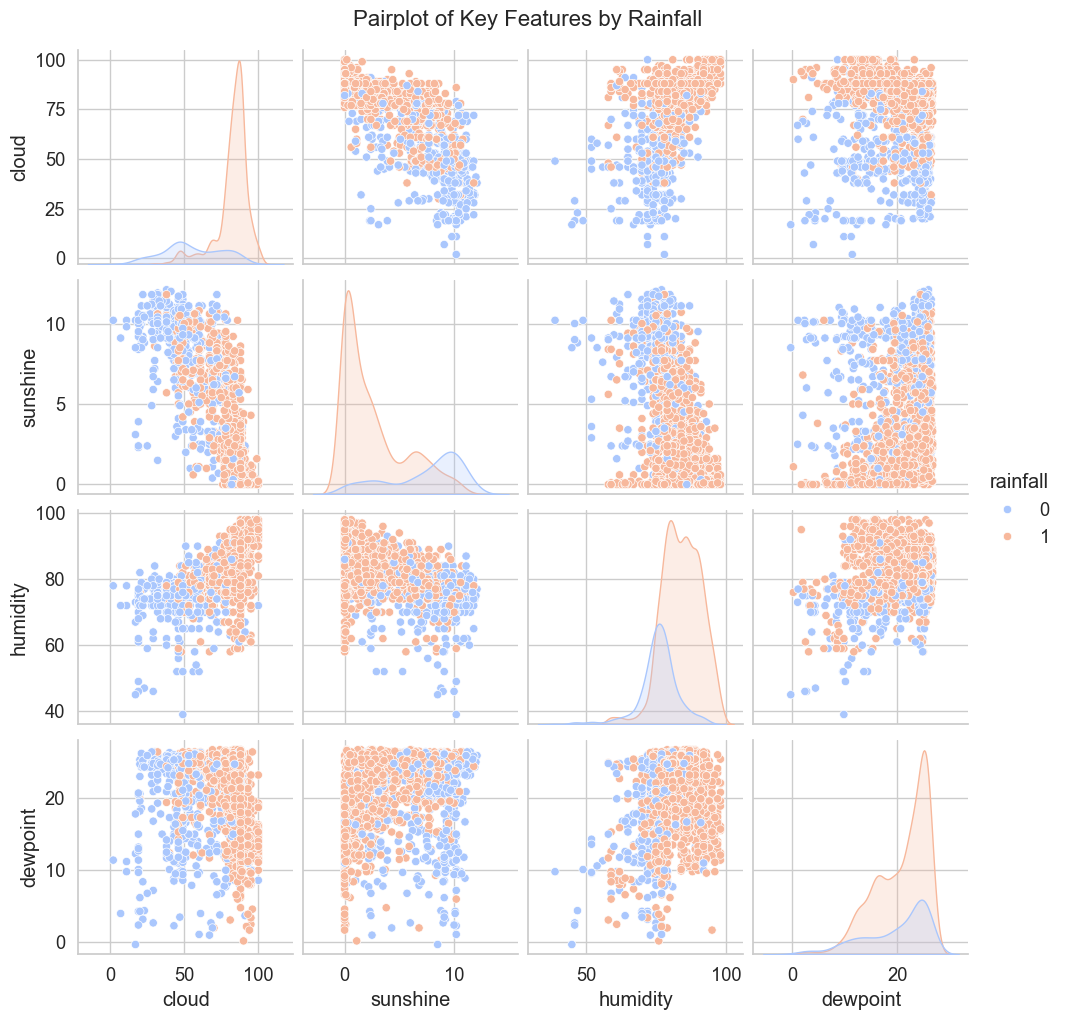

In [24]:
# Pairplot for key features
key_features = ['cloud', 'sunshine', 'humidity', 'dewpoint', 'rainfall']
sns.pairplot(df_train[key_features], hue='rainfall', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairplot of Key Features by Rainfall', y=1.02, fontsize=16)
plt.show()

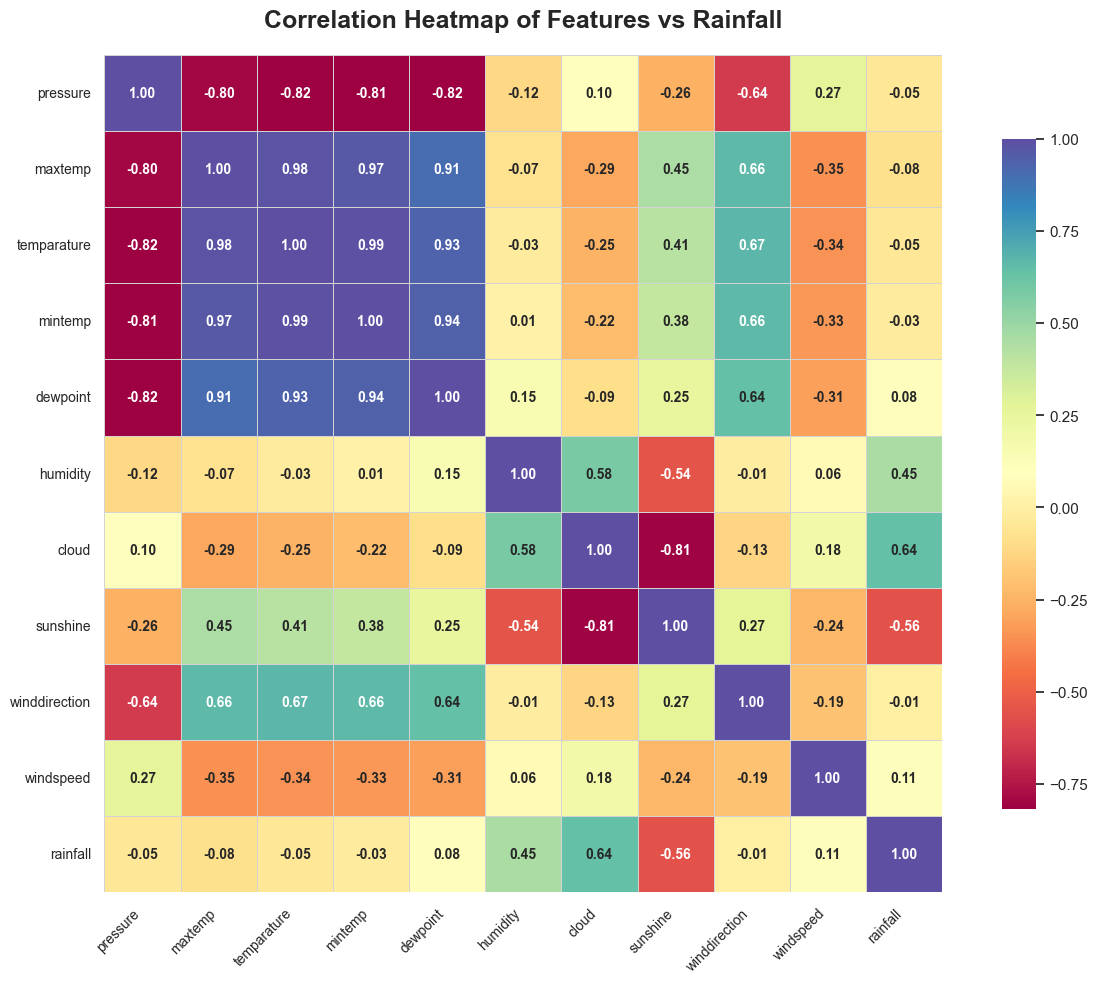

In [26]:
# Set seaborn theme
sns.set_theme(style="white")

# Calculate correlation matrix
corr_matrix = df_train[numerical_variables + ['rainfall']].corr()

# Plot heatmap
plt.figure(figsize=(13, 10))
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="Spectral",  # Vibrant & clean
    linewidths=0.6,
    linecolor='lightgray',
    square=True,
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 10, "weight": "bold"}
)

# Styling
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Correlation Heatmap of Features vs Rainfall', fontsize=18, weight='bold', pad=20)

plt.tight_layout()
plt.show()


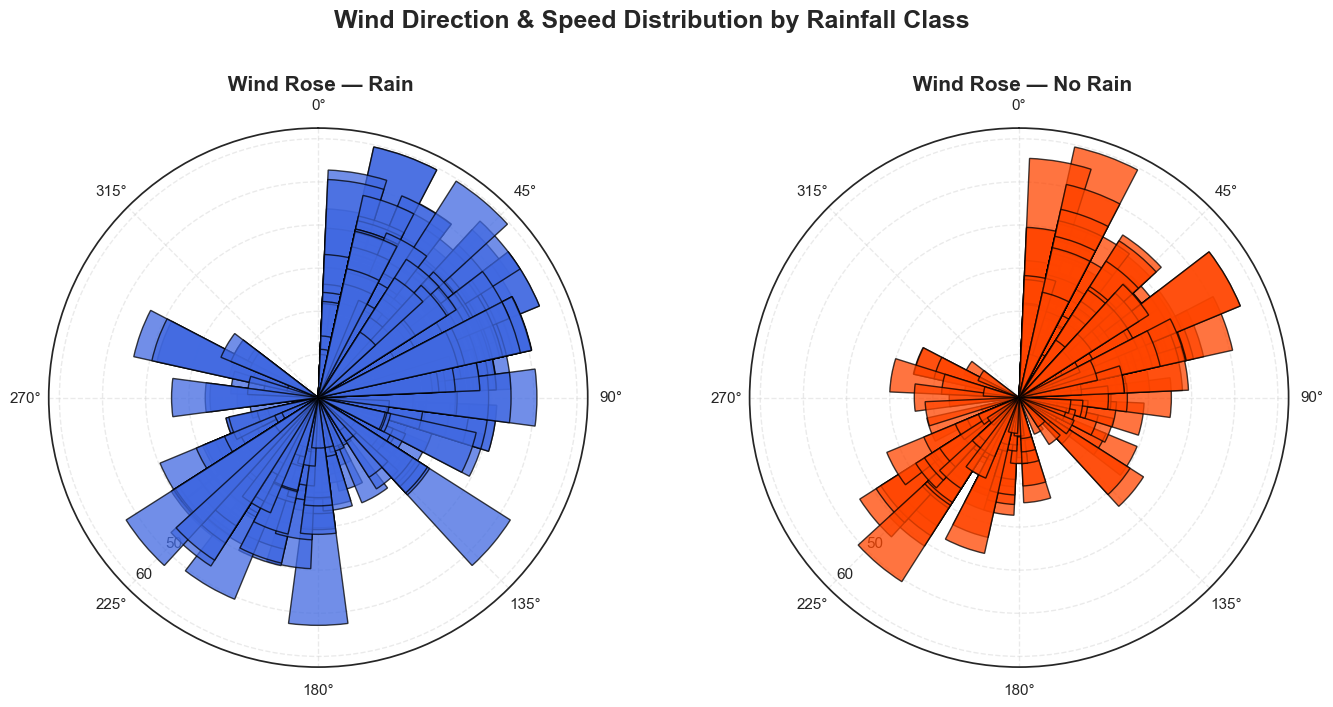

In [28]:
# Subsets for Rain and No Rain
rain_data = df_train[df_train['rainfall'] == 1]
no_rain_data = df_train[df_train['rainfall'] == 0]

# Set up polar plots
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(16, 7))
plt.subplots_adjust(wspace=0.3)

# Common polar settings
for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)
    ax.set_rlabel_position(225)
    ax.grid(True, linestyle='--', alpha=0.4)

# Plot for Rain
axes[0].bar(
    np.deg2rad(rain_data['winddirection']),
    rain_data['windspeed'],
    width=np.pi/12,
    color='royalblue',
    edgecolor='black',
    alpha=0.75
)
axes[0].set_title(' Wind Rose — Rain', fontsize=15, weight='bold')

# Plot for No Rain
axes[1].bar(
    np.deg2rad(no_rain_data['winddirection']),
    no_rain_data['windspeed'],
    width=np.pi/12,
    color='orangered',
    edgecolor='black',
    alpha=0.75
)
axes[1].set_title(' Wind Rose — No Rain', fontsize=15, weight='bold')

# Final touches
fig.suptitle(' Wind Direction & Speed Distribution by Rainfall Class', fontsize=18, weight='bold', y=1.05)
plt.show()


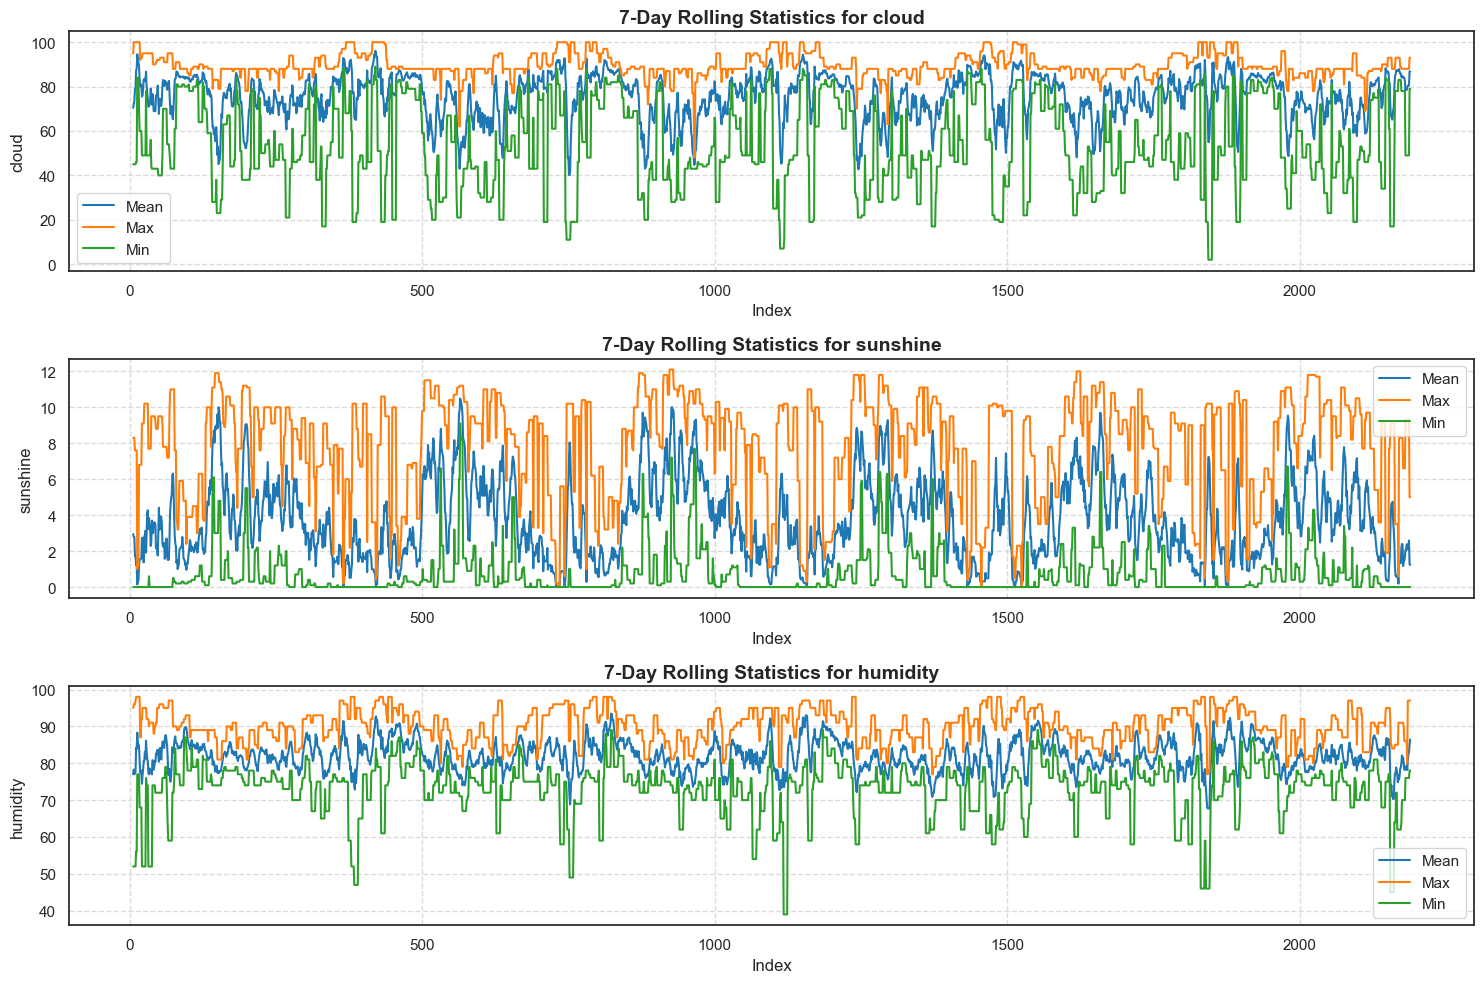

In [35]:
# Rolling statistics for key features
key_features = ['cloud', 'sunshine', 'humidity']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 1, i)
    rolling_mean = df_train[feature].rolling(window=7).mean()
    rolling_max = df_train[feature].rolling(window=7).max()
    rolling_min = df_train[feature].rolling(window=7).min()
    plt.plot(rolling_mean, label='Mean', color=colors[0])
    plt.plot(rolling_max, label='Max', color=colors[1])
    plt.plot(rolling_min, label='Min', color=colors[2])
    plt.title(f'7-Day Rolling Statistics for {feature}', fontsize=14)
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<h2 style="background-color:#006A71; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold;">
    Feature Engineering 
</h2>


In [36]:
# Feature Engineering Function
def preprocess_weather_data(data):
    data["dew_humidity"] = data["dewpoint"] * data["humidity"]
    data["cloud_windspeed"] = data["cloud"] * data["windspeed"]
    data["cloud_to_humidity"] = data["cloud"] / data["humidity"]
    data["temp_to_sunshine"] = data["sunshine"] / data["temparature"]
    data["wind_temp_interaction"] = data["windspeed"] * data["temparature"]
    data["cloud_sun_ratio"] = data["cloud"] / (data["sunshine"] + 1)
    data["dew_humidity/sun"] = data["dewpoint"] * data["humidity"] / (data["sunshine"] + 1)
    data["dew_humidity_+"] = data["dewpoint"] * data["humidity"]
    data["humidity_sunshine_*"] = data["humidity"] * data["sunshine"]
    data["cloud_humidity/pressure"] = (data["cloud"] * data["humidity"]) / data["pressure"]
    data['month'] = ((data['day'] - 1) // 30 + 1).clip(upper=12)
    data['season'] = data['month'].apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 0)
    data['season_cloud_trend'] = data['cloud'] * data['season']
    data['season_cloud_deviation'] = data['cloud'] - data.groupby('season')['cloud'].transform('mean')
    data['season_temperature'] = data['temparature'] * data['season']
    data = data.drop(columns=["month", "maxtemp", "winddirection", "humidity", "temparature", "pressure", "day", "season"])
    return data

# Apply to train and test datasets
df_train_processed = preprocess_weather_data(df_train.copy())
df_test_processed = preprocess_weather_data(df_test.copy())

In [37]:
# Prepare features and target
X = df_train_processed.drop(['rainfall', 'id'], axis=1)
y = df_train_processed['rainfall']
X_test = df_test_processed.drop(['id'], axis=1)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

<h2 style="background-color:#006A71; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold;">
    Model
</h2>


CatBoost: AUC = 0.8829


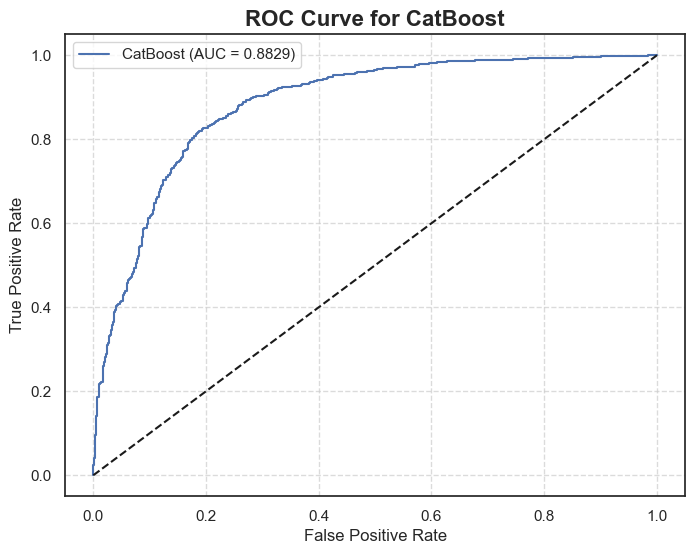

In [38]:
# Define models
models = {
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0, iterations=200, learning_rate=0.1, depth=6)
}

# Train and evaluate CatBoost (best model from previous analysis)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = {}
roc_curves = {}

for name, model in models.items():
    oof_preds = np.zeros(len(y))
    for train_idx, val_idx in skf.split(X_scaled, y):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model.fit(X_train, y_train)
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y, oof_preds)
    auc_scores[name] = auc_score
    fpr, tpr, _ = roc_curve(y, oof_preds)
    roc_curves[name] = (fpr, tpr, auc_score)
    print(f"{name}: AUC = {auc_score:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_score) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for CatBoost", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

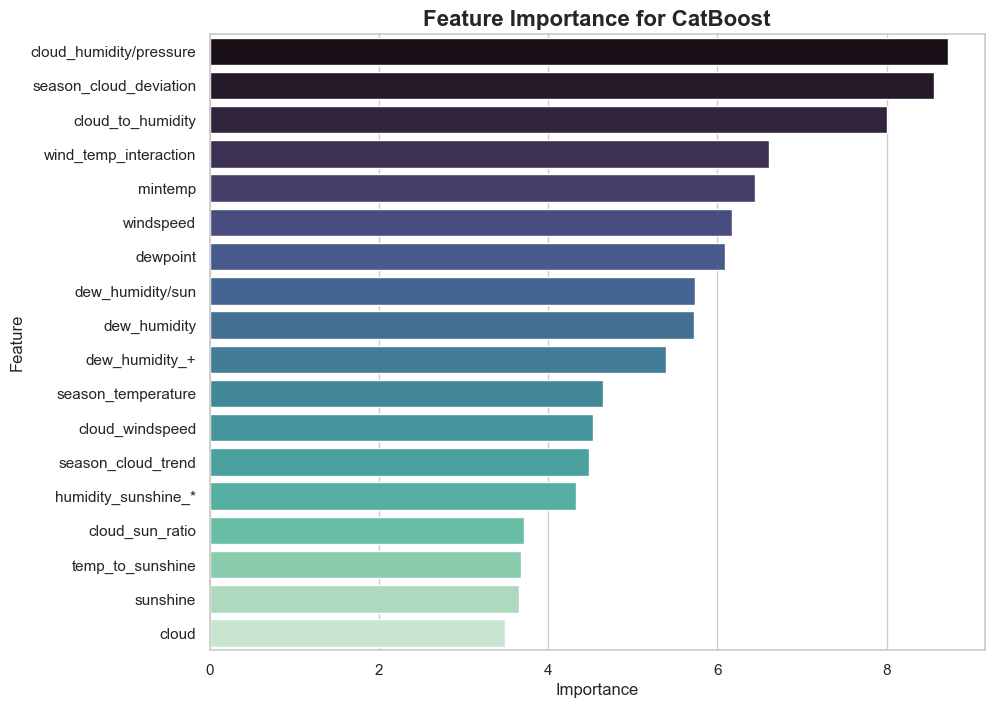

In [43]:
# Feature importance for CatBoost
feature_names = X.columns
feature_importance = models["CatBoost"].feature_importances_
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette="mako")
plt.title('Feature Importance for CatBoost', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

<h2 style="background-color:#006A71; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold;">
    Save the model and scaler
</h2>


In [ ]:
# # Save the model and scaler
# with open("catboost_model1.pkl", "wb") as f:
#     pickle.dump(models["CatBoost"], f)
# with open("scaler1.pkl", "wb") as f:
#     pickle.dump(scaler, f)
# print("Model and scaler saved as 'catboost_model1.pkl' and 'scaler1.pkl'.")

Model and scaler saved as 'catboost_model1.pkl' and 'scaler1.pkl'.


<h2 style="background-color:#006A71; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold;">
    End
</h2>
